##SETUP

In [2]:
import os
import time
import pandas as pd
import numpy as np
# Android ADB
from scrcpy import Client, const

# Image processing
from PIL import Image
import cv2
import pytesseract
# Notebook
from IPython.display import display,clear_output
from tqdm.notebook import trange, tqdm
# internal
import bot_core
import bot_perception

import importlib
# reload all internal to update changes
importlib.reload(bot_core)
importlib.reload(bot_perception)



bot = bot_core.Bot()

In [3]:
# Check if alive
bot.client.control.text("test")


b'\x01\x00\x00\x00\x04test'

## Look for icons

In [106]:
# Check current screen
bot.get_current_icons(False)

,icon,available,"pos [X,Y]"
0,0cont_button.png,False,"(0, 0)"
1,1quit.png,False,"(0, 0)"
2,back_button.png,False,"(0, 0)"
3,battle_icon.png,False,"(0, 0)"
4,fighting.png,True,"(669, 1359)"
5,pvp_button.png,False,"(0, 0)"


In [2]:
bot.getScreen()

In [7]:
names=bot.scan_grid(new=False)
grid_df=bot_perception.grid_status(names)
df_split,unit_series, df_groups, group_keys=bot_core.grid_meta_info(grid_df)
display(grid_df)

,grid_id,unit,probability,rank,rank_error,position,Age
0,icon_0,chemist.png,662.0,1,6305.5,"[0, 0]",0.0
1,icon_1,empty.png,700.0,0,0.0,"[0, 1]",0.0
2,icon_2,empty.png,700.0,0,0.0,"[0, 2]",0.0
3,icon_3,crystal.png,337.0,2,345.0,"[0, 3]",0.0
4,icon_4,empty.png,700.0,0,0.0,"[0, 4]",0.0
5,icon_5,empty.png,700.0,0,0.0,"[1, 0]",0.0
6,icon_6,empty.png,999.0,0,0.0,"[1, 1]",0.0
7,icon_7,empty.png,999.0,0,0.0,"[1, 2]",0.0
8,icon_8,empty.png,999.0,0,0.0,"[1, 3]",0.0
9,icon_9,empty.png,700.0,0,0.0,"[1, 4]",0.0


## Rank v3 (Logistical Regression)

In [ ]:
bot_perception.add_grid_to_dataset()

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

def load_dataset(folder):
    X_train=[]
    Y_train=[]
    for file in os.listdir(folder):
        if file.endswith(".png"):
            X_train.append(cv2.imread(folder+file,0))
            Y_train.append(file.split('_input')[0])
    X_train=np.array(X_train)
    data_shape = X_train.shape
    X_train=X_train.reshape(data_shape[0],data_shape[1]*data_shape[2])
    Y_train=np.array(Y_train, dtype=int)
    return X_train,Y_train

X_train,Y_train = load_dataset("machine_learning\\inputs\\")
X_val,Y_val = load_dataset("machine_learning\\validation\\")
# train logistic regression model
logreg =  LogisticRegression()
logreg.fit(X_train,Y_train)
# Evaluate model
y_pred=logreg.predict(X_val)
print(classification_report(Y_val,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



In [46]:
import pickle
# Save model
with open('machine_learning\\model.pkl', 'wb') as f:
    pickle.dump(logreg, f)


In [24]:
import pickle
import cv2

def match_rank(filename):
    img = cv2.imread(filename,0)
    edges = cv2.Canny(img,50,100)
    # Load model (will be cached)
    with open('rank_model.pkl', 'rb') as f:
        logreg = pickle.load(f)
        classes = logreg.classes_
    prob = logreg.predict_proba(edges.reshape(1,-1))
    return prob.argmax(),prob.max()

for i in range(15):
    rank_guess,prob = match_rank(f'OCR_inputs/icon_{i}.png')
    print(rank_guess,prob)

2 0.9999998414132941
2 0.9999997178671888
0 0.9999999998424642
5 0.9999692850660801
3 0.9999893574845153
2 0.9999823050525939
5 0.9999999970478954
1 0.9999836763048254
3 0.9999999556610535
3 0.9999999523207748
3 0.9999999693575885
3 0.9999999666885342
4 0.999999990084567
3 0.9999999924562438
2 0.9999999983616483


In [14]:
prob


array([[9.99999997e-01, 8.41872421e-10, 3.96738829e-10, 2.46101233e-10,
        5.94819051e-10, 4.96650949e-10, 1.27066787e-10, 5.10736250e-10]])

In [37]:
def quick_train_model():
    X_train,Y_train = load_dataset("machine_learning\\inputs\\")
    # train logistic regression model
    logreg =  LogisticRegression()
    logreg.fit(X_train,Y_train)
    return logreg

quick_train_model()

LogisticRegression()

## Rank v2

In [11]:
def get_poly(filename,ref,i=4,shape=(120, 120),debug=False):
    # read image as grayscale
    img = cv2.imread(filename,0)
    # Find edges in image
    edges = cv2.Canny(img,50,100)
    # read reference image
    img_ref = cv2.imread(ref,0)
    img_ref = cv2.GaussianBlur(img_ref,(5,5),0)
    # Apply filter
    img_match = edges &img_ref
    img_match = cv2.GaussianBlur(img_match,(5,5),0)
    # pick top polygon
    cnts=bot_perception.find_polygon(img_match,1)
    # Approximate Polygon         # Change arclength to expect of rank polygon
    i=3
    approx=cv2.approxPolyDP(cnts,1.5**i*0.01*cv2.arcLength(cnts,True),True)
    if debug:
        return approx,cnts,img_match,edges,img
    if approx is None:
       return 0, [0]*4
    return approx
# Returns guess of unit rank
def match_rank(filename):
    # Load dictionary with expected corner positions
    corner_dict={
    'rank2':np.array([[10,10],[110,110]]),
    'rank3':np.array([[5,10],[115,10],[60,110]]),
    'rank4':np.array([[60,0],[0,60],[60,120],[120,60]]),
    'rank5':np.array([[15,10],[15,80],[60,115],[105,80],[105,10]]),    
        }
    match_errors=[]
    for rank in corner_dict:
        target=f'unit_rank/{rank}_bin.png'
        # Get polygon of image
        target_corners=get_poly(filename,target)
        polygon_error = 0
        # Take mean square loss for each corner
        for corner in corner_dict[rank]:
            polygon_error += bot_perception.mean_square(target_corners,corner)
        match_errors.append(polygon_error)
    # Prefer higher ranks 
    match_errors = match_errors *np.array([10,3,2,1])
    np.array(match_errors)
    rank_guess=np.array(match_errors).argmin()
    if match_errors[rank_guess]>1000:
        rank_guess = -1 # rank 1 if none are good match
    return rank_guess+2, match_errors[rank_guess]



In [6]:
# Scan grid
names=bot.scan_grid()
grid_df=bot_perception.grid_status(names)
display(grid_df)
# Non empty names
curr_units_df=grid_df[grid_df['unit']!='empty.png'].reset_index(drop=True)
live_units=list(curr_units_df['grid_id']+'.png')

for row in curr_units_df.iterrows():
    target = row[1]['grid_id']+'.png'
    unit = row[1]['unit']
    filename=f'OCR_inputs/{target}'
    rank_guess,match_errors = match_rank(filename) # Rank 3, check first if rank 5 is better match, then rank 3
    print(f'Guessed rank: {rank_guess} for {target}', match_errors)


,grid_id,unit,probability,rank,rank_error,position,Age
0,icon_0,chemist.png,662.0,1,6305.5,"[0, 0]",0.0
1,icon_1,empty.png,700.0,0,0.0,"[0, 1]",0.0
2,icon_2,empty.png,700.0,0,0.0,"[0, 2]",0.0
3,icon_3,crystal.png,337.0,2,345.0,"[0, 3]",0.0
4,icon_4,empty.png,700.0,0,0.0,"[0, 4]",0.0
5,icon_5,empty.png,700.0,0,0.0,"[1, 0]",0.0
6,icon_6,empty.png,999.0,0,0.0,"[1, 1]",0.0
7,icon_7,empty.png,999.0,0,0.0,"[1, 2]",0.0
8,icon_8,empty.png,999.0,0,0.0,"[1, 3]",0.0
9,icon_9,empty.png,700.0,0,0.0,"[1, 4]",0.0


NameError: name 'match_rank' is not defined

In [3]:
grid_df['Age'].mean()

NameError: name 'grid_df' is not defined

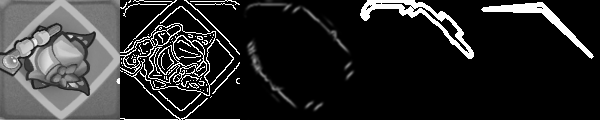

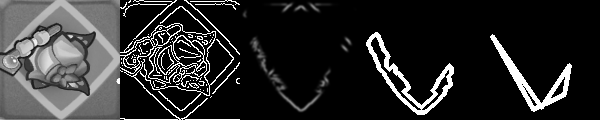

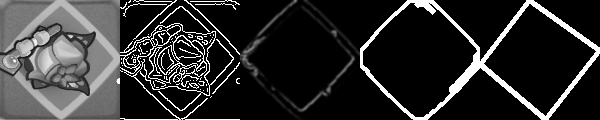

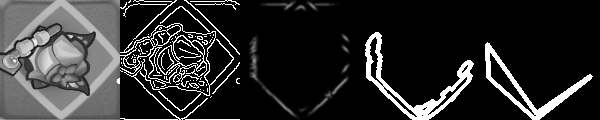

Guessed rank: 4 for OCR_inputs/icon_13.png 264.0


In [15]:
target = 'OCR_inputs/icon_13.png'
for ref in os.listdir("unit_rank")[1:]:
    figs = []
    ref=f'unit_rank/{ref}'
    approx,cnts,img_match,edges,img = get_poly(target,ref,debug=True)
    figs.insert(0,bot_perception.show_contour(approx))
    figs.insert(0,bot_perception.show_contour(cnts))
    figs.insert(0,img_match)
    figs.insert(0,edges)
    figs.insert(0,img)
    display(Image.fromarray(np.hstack(figs)))
rank_guess,match_errors = match_rank(target) # Rank 3, check first if rank 5 is better match, then rank 3
print(f'Guessed rank: {rank_guess} for {target}', match_errors)

5


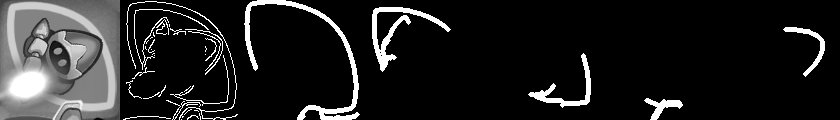

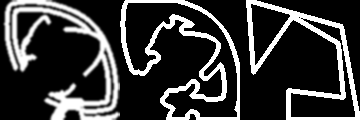

Guessed rank: 1 for OCR_inputs/icon_4.png 1033.5


In [105]:
target = 'OCR_inputs/icon_4.png'
approx,cnts,img_cnt,cnts_raw,edges,img = get_poly(target,debug=True)
#for cnt in cnts:
#    print(cv2.contourArea(cnt))
print(len(cnts_raw))
#figs=[show_contour(polygon) for polygon in cnts_raw[0:10]]
figs=[bot_perception.show_contour(polygon) for polygon in bot_perception.find_polygon(edges,5)]
figs.insert(0,edges)
figs.insert(0,img)
display(Image.fromarray(np.hstack(figs)))
rank_guess,match_errors = bot_perception.match_rank(target) # Rank 3, check first if rank 5 is better match, then rank 3
fig=bot_perception.show_contour(approx)
display(Image.fromarray(np.hstack([img_cnt,bot_perception.show_contour(cnts),fig])))
print(f'Guessed rank: {rank_guess} for {target}', match_errors)

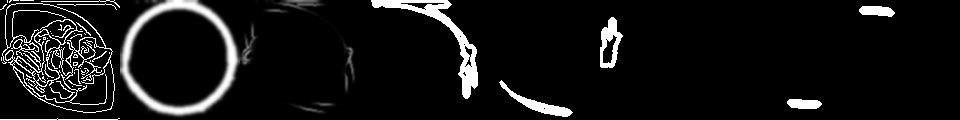

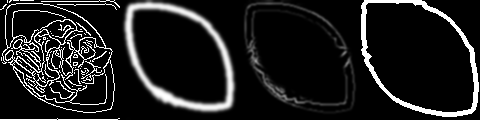

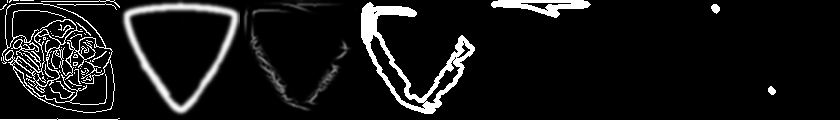

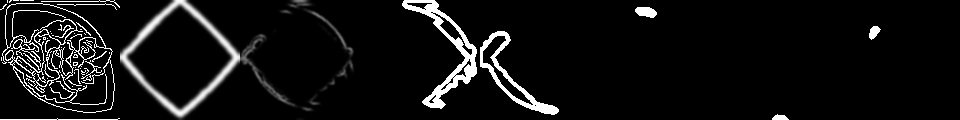

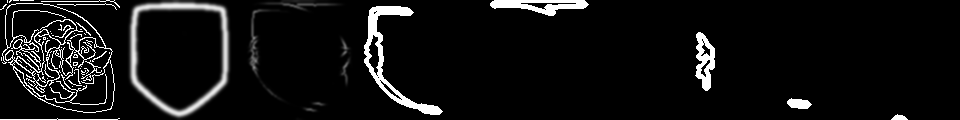

In [186]:
# read image as grayscale
img = cv2.imread('OCR_inputs/icon_11.png',0)
# Find edges in image
img = cv2.Canny(img,50,100)
for target in os.listdir("unit_rank"):
    target=f'unit_rank/{target}'
    img_ref = cv2.imread(target,0)
    img_ref = cv2.GaussianBlur(img_ref,(9,9),0)

    # Apply filter
    img_match = img &img_ref
    img_match = cv2.GaussianBlur(img_match,(5,5),0)
    #display(Image.fromarray(np.hstack([img,img_ref,img &img_ref])))
    figs=[bot_perception.show_contour(polygon) for polygon in bot_perception.find_polygon(img_match,5)]
    figs.insert(0,img_match)
    figs.insert(0,img_ref)
    figs.insert(0,img)
    display(Image.fromarray(np.hstack(figs)))

## OpenCV Feature2D - unit detection

In [16]:
import matplotlib.pyplot as plt 
img1 = cv2.imread('units/priest.png',cv2.IMREAD_GRAYSCALE)          # queryImage
img2 = cv2.imread('OCR_inputs/icon_11.png',cv2.IMREAD_GRAYSCALE) # trainImage
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
print(len(matches))
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()
unit_df= bot_perception.match_unit('OCR_inputs/icon_11.png',guess_unit=False)
display(unit_df)
bot_perception.match_unit('OCR_inputs/icon_11.png',guess_unit=True)


0


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [18]:
bot_perception.match_unit('OCR_inputs/icon_2.png')

['icon_2', 'alchemist.png', 215.0]

## Unit Rank

In [5]:
rank_guess,match_errors =bot_perception.match_rank('OCR_inputs/icon_2.png')
print(f'Guessed rank: {rank_guess},', match_errors)

Guessed rank: 1, 1552.5


In [6]:
def unit_rank(filename):
    cnts=get_poly(filename)
    rank_guess,match_errors = bot_core.match_rank(cnts) # Rank 3, check first if rank 5 is better match, then rank 3
    fig=bot_core.show_contour(cnts)
    display(Image.fromarray(fig))
    print(f'Guessed rank: {rank_guess},', match_errors)

# Scan grid
names=bot.scan_grid()
grid_df=bot_perception.grid_status(names)
# Non empty names
curr_units_df=grid_df[grid_df['unit']!='empty.png'].reset_index(drop=True)
live_units=list(curr_units_df['grid_id']+'.png')
contour=[]
guesses=[]
for row in curr_units_df.iterrows():
    target = row[1]['grid_id']+'.png'
    unit = row[1]['unit']
    filename=f'OCR_inputs/{target}'
    cnts=bot_perception.get_poly(filename)
    rank_guess,match_errors = bot_perception.match_rank(filename) # Rank 3, check first if rank 5 is better match, then rank 3
    print(f'Guessed rank: {rank_guess} for {target}', match_errors)
    contour.append(cnts)
    guesses.append(rank_guess)

figs=[bot_perception.show_contour(polygon) for polygon in contour]
display(Image.fromarray(np.hstack(figs)))

# failed: 4 and 12 both marked 2 instead of 1

TypeError: 'NoneType' object is not subscriptable

In [7]:
target = 'OCR_inputs/icon_5.png'
approx,cnts,img_cnt,cnts_raw,edges,img = bot_perception.get_poly(target,debug=True)
#for cnt in cnts:
#    print(cv2.contourArea(cnt))
print(len(cnts_raw))
#figs=[show_contour(polygon) for polygon in cnts_raw[0:10]]
figs=[bot_perception.show_contour(polygon) for polygon in bot_perception.find_polygon(edges,5)]
figs.insert(0,edges)
figs.insert(0,img)
display(Image.fromarray(np.hstack(figs)))
rank_guess,match_errors = bot_perception.match_rank(target) # Rank 3, check first if rank 5 is better match, then rank 3
fig=bot_perception.show_contour(approx)
display(Image.fromarray(np.hstack([img_cnt,bot_perception.show_contour(cnts),fig])))
print(f'Guessed rank: {rank_guess} for {target}', match_errors)

TypeError: get_poly() missing 1 required positional argument: 'ref'

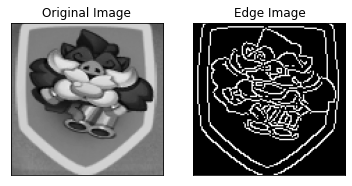

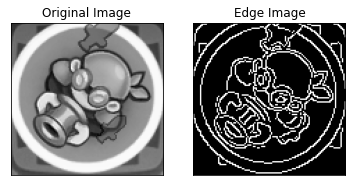

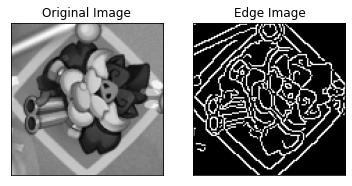

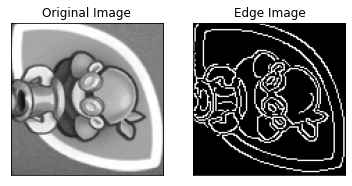

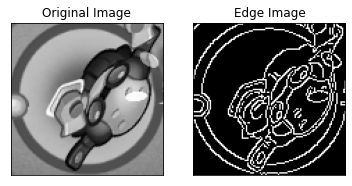

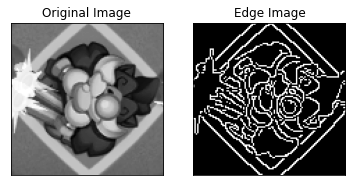

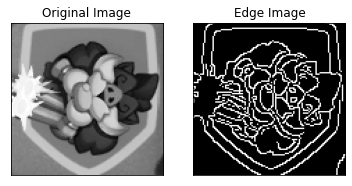

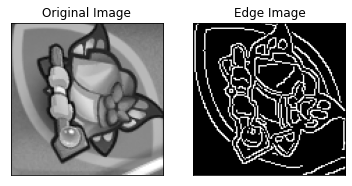

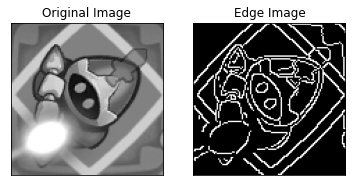

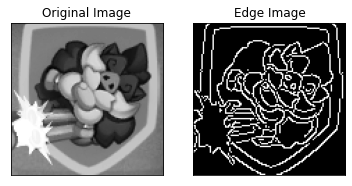

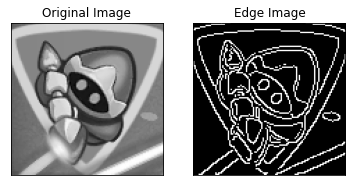

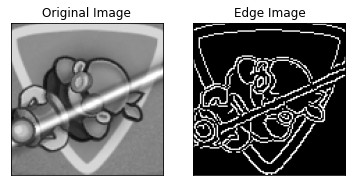

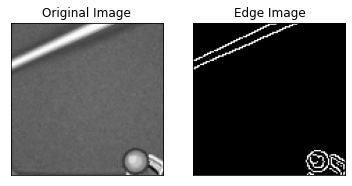

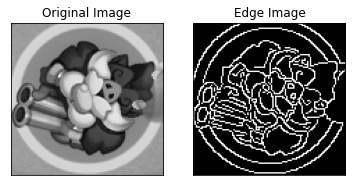

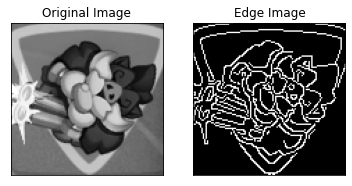

In [8]:
from matplotlib import pyplot as plt


for target in os.listdir("OCR_inputs"):
    target=f'OCR_inputs/{target}'
    img = cv2.imread(target,0)
    keep=5
    img=img[keep:-keep,keep:-keep]
    #img = cv2.GaussianBlur(img,(3,3),0)
    edges = cv2.Canny(img,100,200)

    plt.subplot(121),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()

In [275]:
match_errors *np.array([4,3,2,1])

array([1788. ,  670.5, 3816. ,  273.5])

In [207]:
img[115].mean()
img[0:5].mean()

161.925

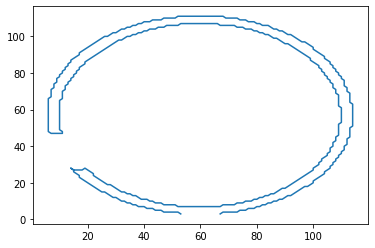

In [32]:
cnts[0]
import matplotlib.pyplot as plt
cords=cnts[0]
cords[:,0,1]

plt.plot(cords[:,0,0],cords[:,0,1])
plt.show()

In [32]:
#Feature detection in query image with ORB detector
def feature_match(img_query,img_train):
        # Initiate SIFT detector
        sift = cv2.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img_query,None) # queryImage
        kp2, des2 = sift.detectAndCompute(img_train,None) # trainImage
        # BFMatcher with default params
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,des2, k=2)
        matches = sorted(matches, key = lambda x:x[0].distance)
        return matches

In [ ]:
# Update units in current deck from database

# check images in all files folder,
# move current units into special folder during fight

## Match Unit

In [10]:
unit_df= bot_perception.match_unit('OCR_inputs/icon_5.png',guess_unit=False)
display(unit_df)
bot_perception.match_unit('OCR_inputs/icon_5.png')


,icon_5,feature_distance,num_match
0,chemist.png,687.0,28
1,crystal.png,208.0,17
2,dryad.png,667.0,17
3,empty.png,700.0,0
4,hunter.png,682.0,20
5,monkey.png,716.0,24


['icon_5', 'crystal.png', 208.0]